# 📊 Evaluation Benchmarks - Baseline Classifier vs Ground Truth


In [15]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Charger les données

In [16]:
# Load ground truth annotations (created by Claude)
with open('../data/ground_truth_annotations.json', 'r', encoding='utf-8') as f:
    annotations_data = json.load(f)

annotations = {a['title']: a['ground_truth'] for a in annotations_data['annotations']}
print(f"✓ Loaded {len(annotations)} ground truth annotations")
print(f"  Annotator: {annotations_data['annotator']}")
print(f"  Date: {annotations_data['annotation_date']}")

# Show annotation criteria
print("\n📋 Critères d'annotation:")
for level, criteria in annotations_data['annotation_criteria'].items():
    print(f"  • {level}: {criteria[:80]}...")

✓ Loaded 80 ground truth annotations
  Annotator: Claude (AI Assistant)
  Date: 2026-01-21

📋 Critères d'annotation:
  • Beginner: Introduction to concepts, basics, getting started guides, simple explanations, t...
  • Intermediate: Requires some technical background, moderate complexity, practical applications,...
  • Advanced: Deep technical content, production systems, research papers, architecture decisi...


In [17]:
# Load classified articles (model predictions)
classified_articles = []
with open('../data/articles_classified.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        classified_articles.append(json.loads(line))

print(f"✓ Loaded {len(classified_articles)} classified articles")

# Preview
df_classified = pd.DataFrame(classified_articles)
df_classified[['title', 'source', 'topic_prediction', 'topic_confidence']].head()

✓ Loaded 81 classified articles


,title,source,topic_prediction,topic_confidence
0,The Agentic AI Handbook: Production-Ready Patt...,HackerNews,Advanced,0.5471
1,Anthropic's original take home assignment open...,HackerNews,Advanced,0.5787
2,"The percentage of Show HN posts is increasing,...",HackerNews,Advanced,0.3698
3,"A 26,000-year astronomical monument hidden in ...",HackerNews,Advanced,0.5567
4,cURL removes bug bounties,HackerNews,Advanced,0.4276


## 2. Matcher prédictions et ground truth

In [18]:
y_true = []  # Ground truth labels
y_pred = []  # Model predictions
titles = []
confidences = []
sources = []

matched = 0
unmatched_titles = []

for article in classified_articles:
    title = article['title']
    prediction = article['topic_prediction']
    
    # Find matching annotation
    ground_truth = None
    for ann_title, ann_label in annotations.items():
        norm_title = title.lower().strip()
        norm_ann = ann_title.lower().strip()
        if norm_title == norm_ann or norm_title in norm_ann or norm_ann in norm_title:
            ground_truth = ann_label
            break
    
    if ground_truth:
        y_true.append(ground_truth)
        y_pred.append(prediction)
        titles.append(title)
        confidences.append(article.get('topic_confidence', 0))
        sources.append(article.get('source', 'Unknown'))
        matched += 1
    else:
        unmatched_titles.append(title)

print(f"📊 Matched: {matched} articles")
print(f"⚠️ Unmatched: {len(unmatched_titles)} articles")

if unmatched_titles:
    print("\nUnmatched titles:")
    for t in unmatched_titles[:5]:
        print(f"  • {t[:60]}...")

📊 Matched: 76 articles
⚠️ Unmatched: 5 articles

Unmatched titles:
  • When "likers'' go private: Engagement with reputationally ri...
  • Show HN: Ocrbase – pdf → .md/.json document OCR and structur...
  • Engineering as Humanity's Highest Achievement...
  • You Probably Don’t  Need a Vector Database for Your RAG — Ye...
  • Time Series Isn’t Enough: How Graph Neural Networks Change D...


## 3. 📈 Métriques Globales

In [19]:
labels = ['Beginner', 'Intermediate', 'Advanced']

# Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Macro averages (treats all classes equally)
precision_macro = precision_score(y_true, y_pred, labels=labels, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, labels=labels, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, labels=labels, average='macro', zero_division=0)

# Weighted averages (accounts for class imbalance)
precision_weighted = precision_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)

# Display results
print("=" * 60)
print("📈 MÉTRIQUES GLOBALES")
print("=" * 60)
print(f"\n🎯 ACCURACY: {accuracy:.1%}")
print(f"\n📊 Macro Average (toutes classes égales):")
print(f"   Precision: {precision_macro:.1%}")
print(f"   Recall:    {recall_macro:.1%}")
print(f"   F1-Score:  {f1_macro:.1%}")
print(f"\n📊 Weighted Average (pondéré par support):")
print(f"   Precision: {precision_weighted:.1%}")
print(f"   Recall:    {recall_weighted:.1%}")
print(f"   F1-Score:  {f1_weighted:.1%}")

📈 MÉTRIQUES GLOBALES

🎯 ACCURACY: 34.2%

📊 Macro Average (toutes classes égales):
   Precision: 39.8%
   Recall:    42.1%
   F1-Score:  30.7%

📊 Weighted Average (pondéré par support):
   Precision: 41.5%
   Recall:    34.2%
   F1-Score:  28.2%


## 4. 📋 Rapport détaillé par classe

In [20]:
print("📋 CLASSIFICATION REPORT\n")
print(classification_report(y_true, y_pred, labels=labels, zero_division=0))

📋 CLASSIFICATION REPORT

              precision    recall  f1-score   support

    Beginner       0.38      0.19      0.26        26
Intermediate       0.50      0.12      0.20        32
    Advanced       0.31      0.94      0.47        18

    accuracy                           0.34        76
   macro avg       0.40      0.42      0.31        76
weighted avg       0.42      0.34      0.28        76



## 5. 🔢 Matrice de Confusion

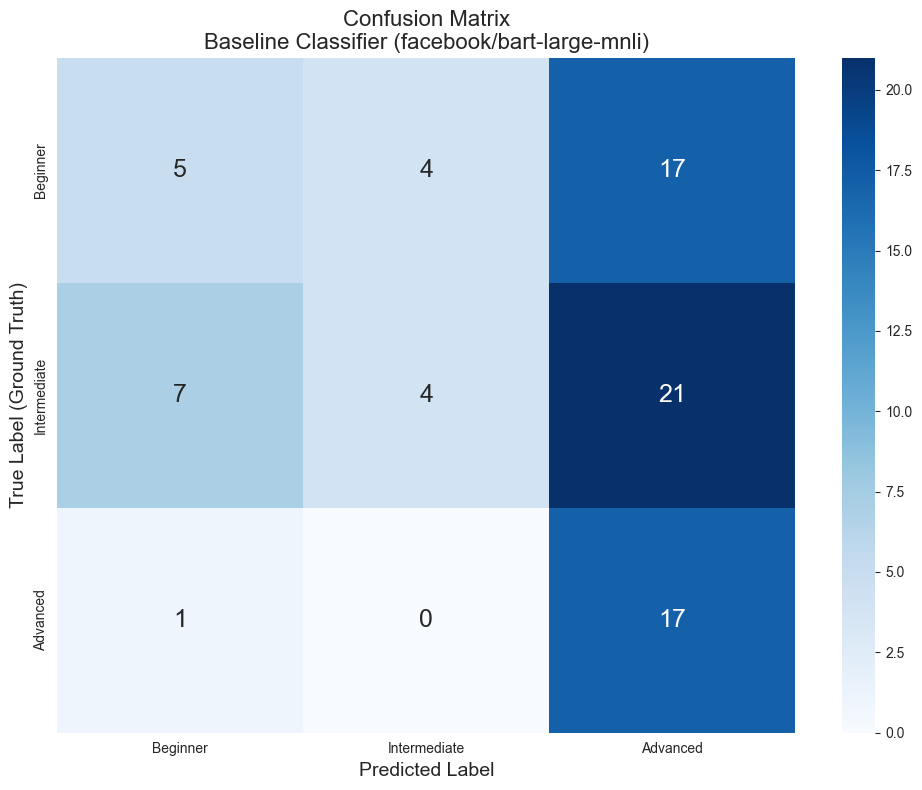

✓ Saved to output/confusion_matrix.png


In [21]:
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={'size': 18})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label (Ground Truth)', fontsize=14)
plt.title('Confusion Matrix\nBaseline Classifier (facebook/bart-large-mnli)', fontsize=16)
plt.tight_layout()
plt.show()

print("✓ Saved to output/confusion_matrix.png")

## 6. 📊 Métriques par classe (graphique)

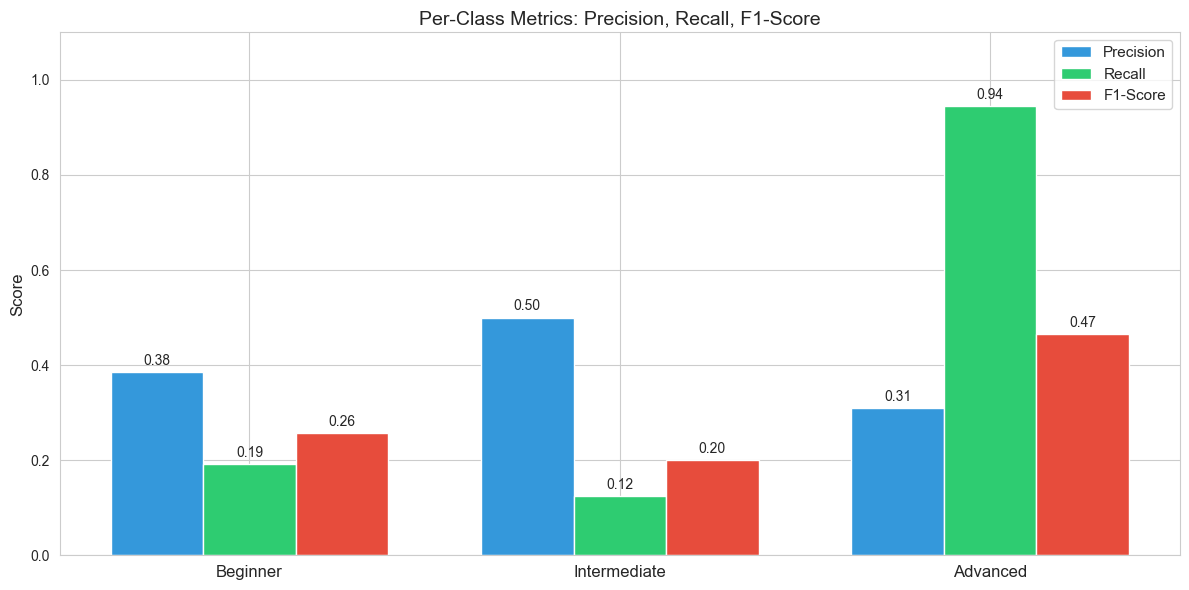

✓ Saved to output/metrics_per_class.png


In [22]:
# Per-class metrics
per_class_precision = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
per_class_recall = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
per_class_f1 = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

# Create bar chart
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, per_class_precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, per_class_recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, per_class_f1, width, label='F1-Score', color='#e74c3c')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Metrics: Precision, Recall, F1-Score', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Saved to output/metrics_per_class.png")

## 7. ❌ Analyse des erreurs

❌ Total errors: 50 / 76 (65.8%)
✓ Correct: 26 / 76 (34.2%)


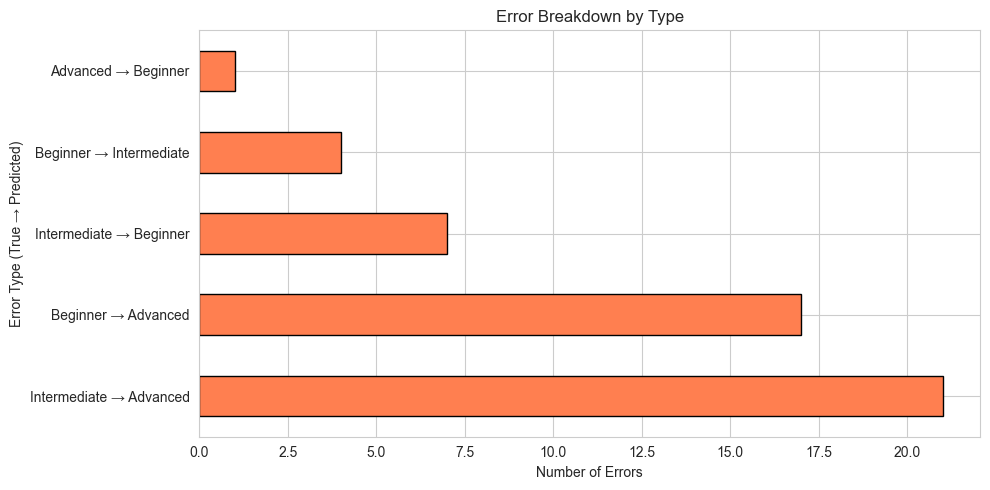

In [23]:
# Collect and display errors
errors = []
for i, (true, pred, title, conf, src) in enumerate(zip(y_true, y_pred, titles, confidences, sources)):
    if true != pred:
        errors.append({'title': title, 'source': src, 'true_label': true, 'predicted': pred, 'confidence': conf})

df_errors = pd.DataFrame(errors)
df_errors['error_type'] = df_errors['true_label'] + ' → ' + df_errors['predicted']

print(f"❌ Total errors: {len(errors)} / {len(y_true)} ({len(errors)/len(y_true)*100:.1f}%)")
print(f"✓ Correct: {len(y_true) - len(errors)} / {len(y_true)} ({(len(y_true)-len(errors))/len(y_true)*100:.1f}%)")

# Error breakdown chart
error_counts = df_errors['error_type'].value_counts()
plt.figure(figsize=(10, 5))
error_counts.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Number of Errors')
plt.ylabel('Error Type (True → Predicted)')
plt.title('Error Breakdown by Type')
plt.tight_layout()
plt.show()

## 8. 📊 Analyse de la confiance

✓ Correct predictions: Mean=47.8%, Std=7.5%
✗ Wrong predictions:   Mean=49.0%, Std=8.3%
→ Confidence similaire = le modèle ne sait pas quand il se trompe!


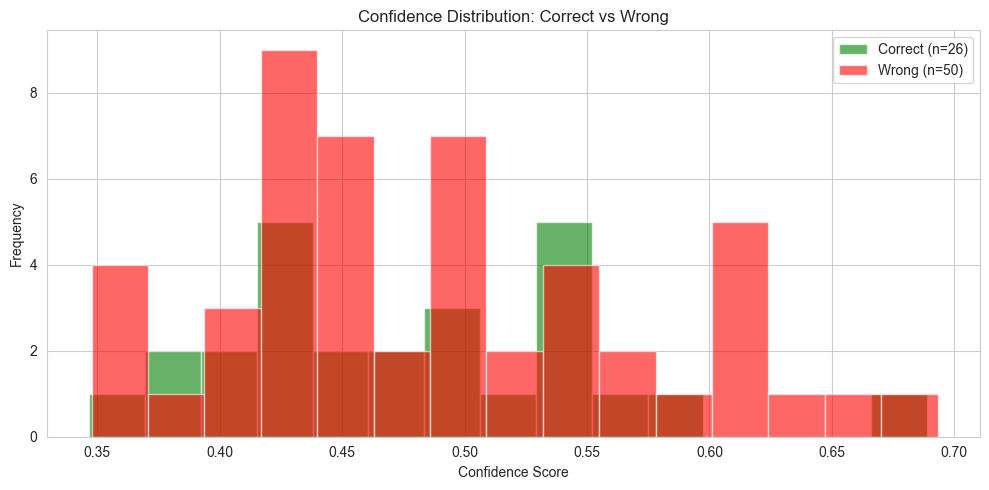

In [24]:
correct_conf = [confidences[i] for i in range(len(y_true)) if y_true[i] == y_pred[i]]
wrong_conf = [confidences[i] for i in range(len(y_true)) if y_true[i] != y_pred[i]]

print(f"✓ Correct predictions: Mean={np.mean(correct_conf):.1%}, Std={np.std(correct_conf):.1%}")
print(f"✗ Wrong predictions:   Mean={np.mean(wrong_conf):.1%}, Std={np.std(wrong_conf):.1%}")
print("→ Confidence similaire = le modèle ne sait pas quand il se trompe!")

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(correct_conf, bins=15, alpha=0.6, label=f'Correct (n={len(correct_conf)})', color='green')
ax.hist(wrong_conf, bins=15, alpha=0.6, label=f'Wrong (n={len(wrong_conf)})', color='red')
ax.set_xlabel('Confidence Score')
ax.set_ylabel('Frequency')
ax.set_title('Confidence Distribution: Correct vs Wrong')
ax.legend()
plt.tight_layout()
plt.show()

## 9. 📰 Comparaison par source

In [25]:
# Source-wise accuracy
source_results = {}
for i, src in enumerate(sources):
    if src not in source_results:
        source_results[src] = {'correct': 0, 'total': 0, 'y_true': [], 'y_pred': []}
    source_results[src]['total'] += 1
    source_results[src]['y_true'].append(y_true[i])
    source_results[src]['y_pred'].append(y_pred[i])
    if y_true[i] == y_pred[i]:
        source_results[src]['correct'] += 1

print("📰 SOURCE-WISE PERFORMANCE")
print("=" * 60)

for src, res in source_results.items():
    acc = res['correct'] / res['total'] if res['total'] > 0 else 0
    f1 = f1_score(res['y_true'], res['y_pred'], labels=labels, average='weighted', zero_division=0)
    print(f"\n📌 {src}:")
    print(f"   Accuracy: {acc:.1%} ({res['correct']}/{res['total']})")
    print(f"   F1-Score (weighted): {f1:.1%}")

📰 SOURCE-WISE PERFORMANCE

📌 HackerNews:
   Accuracy: 35.1% (20/57)
   F1-Score (weighted): 30.3%

📌 TowardsDataScience:
   Accuracy: 31.6% (6/19)
   F1-Score (weighted): 21.7%
